# Main Workflow for Stock Prediction

This notebook imports configuration and utility modules and then downloads data, preprocesses it, builds a model, trains it, makes predictions, and saves the model and scaler.

In [39]:
import config
import data_utils
import model_utils
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
import pickle

In [41]:
# Reload modules during interactive development (if needed)
import importlib
importlib.reload(config)
importlib.reload(data_utils)
importlib.reload(model_utils)

<module 'model_utils' from 'c:\\Users\\rhima\\Z_Code\\Stock-Price-Prediction-YFinance-LSTM-RNN\\prototyping\\StocksGPT\\model_utils.py'>

## 1. Data Download & Preprocessing

In [31]:
# Download the dataset using our data_utils module
dataset = data_utils.download_data()
print(dataset.head(200))

[*********************100%***********************]  1 of 1 completed

Price                           Close        High         Low        Open  \
Ticker                           NVDA        NVDA        NVDA        NVDA   
Datetime                                                                    
2025-03-24 13:30:00+00:00  120.199997  120.230003  119.730003  119.889999   
2025-03-24 13:31:00+00:00  120.210403  120.639999  120.110001  120.209900   
2025-03-24 13:32:00+00:00  120.434998  120.510002  120.050003  120.150002   
2025-03-24 13:33:00+00:00  120.738701  121.070000  120.309998  120.434998   
2025-03-24 13:34:00+00:00  120.470802  120.839996  120.389999  120.737900   
...                               ...         ...         ...         ...   
2025-03-25 14:14:00+00:00  119.760002  119.790001  119.590103  119.698502   
2025-03-25 14:15:00+00:00  119.869904  119.900002  119.669998  119.750000   
2025-03-25 14:16:00+00:00  119.938301  119.970001  119.800003  119.860100   
2025-03-25 14:17:00+00:00  119.754997  119.930000  119.739998  119.930000   

## 2. Get Date Splits for Training and Testing

Here we use the config module's function to obtain last week's dates (for training) and current week's dates (for testing).

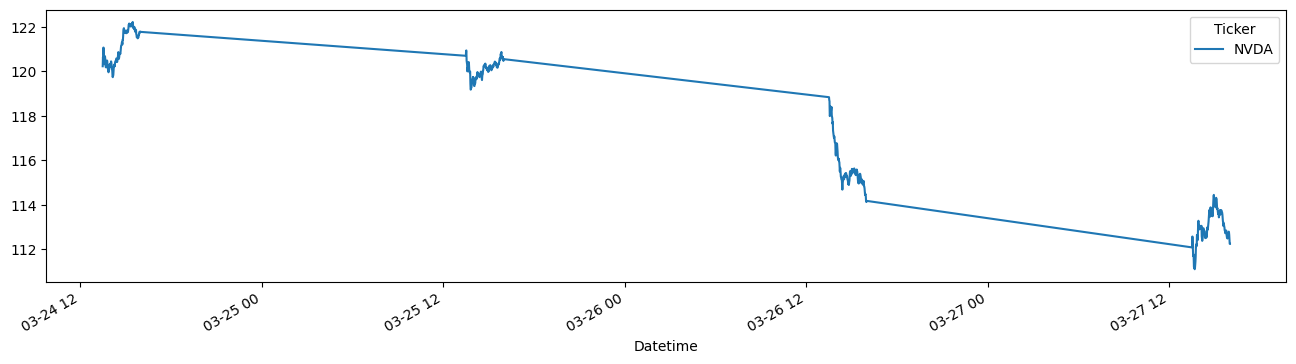

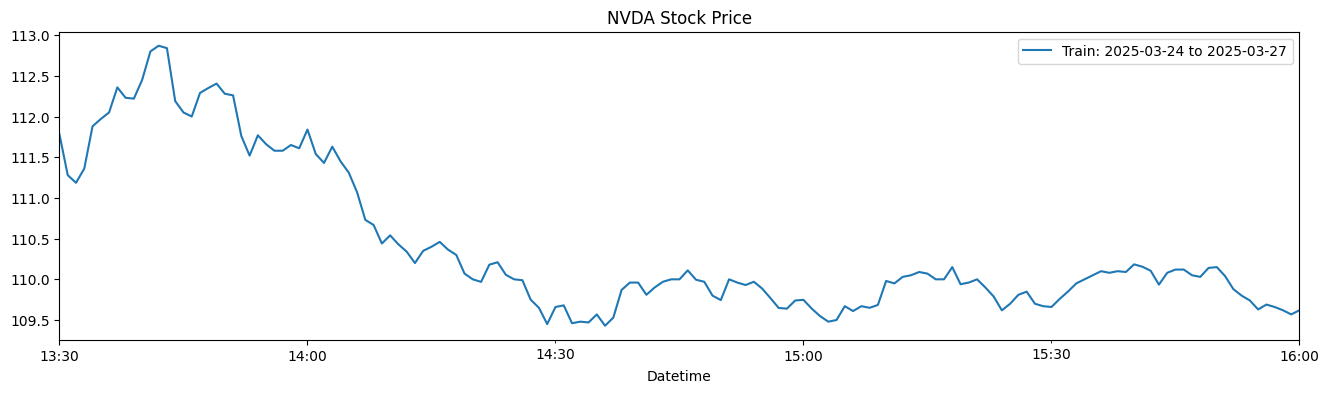

In [32]:
train_start = datetime.datetime(2025, 3, 24, 9, 30)
train_end   = datetime.datetime(2025, 3, 27, 16, 0)
test_start  = datetime.datetime(2025, 3, 28, 9, 30)
test_end    = datetime.datetime(2025, 3, 28, 16, 0)

model_utils.train_test_plot(dataset, train_start, train_end, test_start, test_end)

## 3. Create Training and Testing Datasets

Extract the 'High' prices for the specified date ranges.

In [33]:
training_set = dataset.loc[f"{train_start}":f"{train_end}", "High"].values.reshape(-1, 1)
test_set = dataset.loc[f"{test_start}":f"{test_end}", "High"].values.reshape(-1, 1)

print("Training set shape:", training_set.shape)
print("Test set shape:", test_set.shape)

Training set shape: (602, 1)
Test set shape: (151, 1)


## 4. Scale the Data and Prepare Sequences

We use MinMaxScaler to scale the data and then create sequences for training and testing.

In [42]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Prepare training sequences
X_train, y_train = data_utils.split_sequence(training_set_scaled, config.N_STEPS)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], config.FEATURES)

# Prepare test sequences
inputs = sc.transform(test_set)
X_test, y_test = data_utils.split_sequence(inputs, config.N_STEPS)
X_test = X_test.reshape(X_test.shape[0], config.N_STEPS, config.FEATURES)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (601, 1, 1)
X_test shape: (150, 1, 1)


## 5. Build and Train an LSTM Model

We build an LSTM model using our model_utils module and then train it using the training data.

In [43]:
from keras.models import Sequential

# Build the LSTM model
model_lstm = model_utils.build_lstm_model(config.N_STEPS, config.FEATURES, config.LSTM_UNITS, config.DROPOUT_RATE)
model_lstm.summary()

# Train the model
history = model_lstm.fit(X_train, y_train, epochs=config.EPOCHS, batch_size=config.BATCH_SIZE, verbose=0)
print("Model training completed.")

c:\Users\rhima\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 125)         │        63,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 125)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 50)          │        35,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,151 (543.56 KB)

 Trainable params: 139,151 (543.56 KB)

 Non-trainable params: 0 (0.00 B)

Model training completed.


## 6. Make Predictions and Plot Results

Use the trained model to predict test data and then plot the results.

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


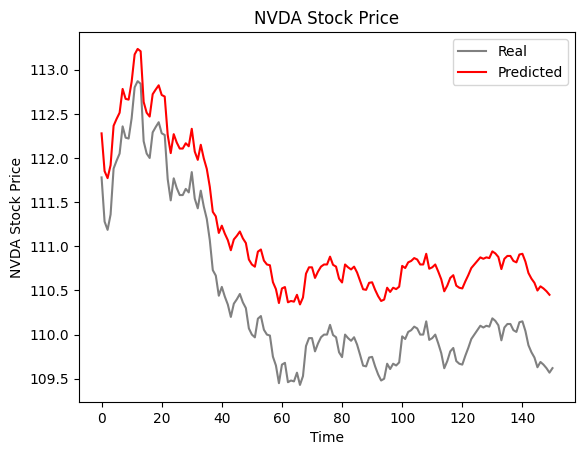

In [44]:
predicted_stock_price = model_lstm.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

model_utils.plot_predictions(test_set, predicted_stock_price, "NVDA Stock Price")

## 7. Save the Model and Scaler

After training, we save the model and scaler for future use.

In [45]:
model_lstm.save(config.MODEL_SAVE_PATH)
with open(config.SCALER_SAVE_PATH, 'wb') as f:
    pickle.dump(sc, f)

print("Model and scaler saved.")

Model and scaler saved.
